<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Exploring the MUSE View of NGC 253**

This notebook demonstrates how to access and explore [MUSE](https://www.eso.org/sci/facilities/develop/instruments/muse.html) observations of the nearby starburst galaxy NGC 253, released as part of the **first public data release of The MUSE View of the Sculptor** programme. The primary data product is a **364 GB (339 GiB)** MUSE mosaic data cube — the largest optical integral field dataset ever released for a nearby galaxy. Rather than downloading the full cube, this notebook shows how to programmatically request **cutouts** — small, spatially and/or spectrally cropped subsets of the full dataset — via ESO’s [Science Archive Facility](https://archive.eso.org/cms.html).

---

### 🗂️ **Data Products**

This release consists of a [Phase 3 validated science product](https://www.eso.org/sci/observing/phase3.html), part of the [108.2289](https://archive.eso.org/scienceportal/home?data_collection=108.2289) data collection (DOI: [10.18727/archive/100](https://doi.org/10.18727/archive/100)). It is a **community-delivered, ESO-ingested dataset** available via the Science Archive Facility:

- 📦 [ADP.2025-07-06T07:52:11.871](https://archive.eso.org/dataset/ADP.2025-07-06T07:52:11.871): full-resolution MUSE mosaic data cube preview
- 📊 [Ancillary DAP maps (~10 GB)](https://dataportal.eso.org/dataPortal/file/ADP.2025-07-06T07:52:11.876): emission-line fluxes (e.g. Hα, [N II], [S II]), stellar and gas kinematics, moment maps  
- 📝 [Official data release description](https://www.eso.org/rm/api/v1/public/releaseDescriptions/236): documentation for the Phase 3 collection
- 📰 [ESO press release (eso2510)](https://www.eso.org/public/news/eso2510/): media highlights from ESO  

---

### 🌀 **Dataset Overview**

The mosaic was built from **103 individual MUSE pointings** in Wide Field Mode (WFM) with extended wavelength coverage. Most pointings (**101**) were taken without adaptive optics (AO), with approx **850 s** exposure times. Two central pointings covering the nuclear region used AO and longer integrations (**≈2000 s**), providing higher spatial resolution across the starburst core. The final mosaic spans approximately **20′ × 5′**, and provides a richly detailed view of the ionised gas, stellar populations, and dust in this prototypical Sculptor group galaxy.

<p align="center">
  <img src="https://cdn.eso.org/images/screen/eso2510a.jpg" alt="MUSE View of NGC 253" width="1000"/>
  <img src="https://cdn.eso.org/images/screen/eso2510b.jpg" alt="MUSE View of NGC 253" width="1000"/>
  <br>
  <em>Figure: MUSE mosaic of the Sculptor galaxy NGC 253, showing stellar continuum and ionised gas (Credit: ESO/E. Congiu et al.).</em>
</p>

---

### ✂️ **What’s a Cutout?**

Given the large file size, downloading the full cube is often impractical. Instead, this notebook shows how to retrieve **cutouts**: smaller FITS cubes extracted from the mosaic, selected by:

- **Spatial** coordinates (RA, Dec)  
- **Spectral** range (wavelength)  
- Or both  

Cutouts allow efficient exploration of targeted regions or specific emission lines without transferring the full dataset.

---

### 💻 **How to Use This Notebook**

You can view this notebook as a static HTML page or run it interactively via [Jupyter](https://jupyter.org/install). It’s also available, alongside other examples, on the ESO [programmatic access page](https://archive.eso.org/programmatic/#SCRIPT).

To interact with the notebook:

- Navigate cells with the arrow keys  
- Execute a cell with `Ctrl+Enter` or `Cmd+Enter` (on Mac)  
- Modify and re-run code to explore custom regions or lines

---

### ⚠️ **Known Issue with Large Requests**

> **Note:** If you receive a timeout error when making a cutout request, this is expected behavior given the size of the dataset. Depending on server load, multiple attempts may be required before the request succeeds. We are actively investigating ways to improve responsiveness for exceptionally large data products like this one.

<hr style="border:2px solid #0281c9"> </hr>

## **Importing the necessary modules**

In [1]:
# from tqdm import tqdm # For displaying progress bars during downloads
import numpy as np  # Numerical operations and array handling
from matplotlib import pyplot as plt  # Plotting library for visualizations

from astropy.coordinates import SkyCoord  # Celestial coordinate handling and conversions
from astropy import units as u  # Physical units and quantities
from astropy.wcs import WCS  # World Coordinate System handling for celestial coordinates
from astropy.io import fits  # FITS file handling for astronomical data
from astropy.utils.data import download_file

from pathlib import Path # Path handling for file system operations
import shutil # File and directory handling

## **Define some useful functions** 

Let’s define a couple of small helpers to request image/spec cube cutouts from the ESO Data Portal via SODA and save them locally with a predictable name (`[dp_id].fits`). The function takes a data product ID (e.g. `ADP.2025-07-06T07:52:11.871`), sky position, radius, optional wavelength band, and a few convenience flags.

In [2]:
from __future__ import annotations

import os
import shutil
from pathlib import Path
import tempfile
import numpy as np
import requests
from astropy.utils.data import download_file  # kept for fallback
# tqdm works in Jupyter via tqdm.auto
try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False


def _sanitize_filename(name: str) -> str:
    """Make a safe filename across platforms."""
    bad = r'\/:*?"<>|'
    return "".join("_" if c in bad else c for c in name)


def _build_soda_url(dp_id, ra, dec, radius, wave_min=None, wave_max=None, prefix=None) -> str:
    """
    Build the SODA sync URL for the ESO Data Portal.
    - CIRCLE: 'RA DEC RADIUS' in degrees
    - BAND: lower and upper wavelength bounds (SODA standard; typically in meters)
    """
    base = "https://dataportal.eso.org/dataPortal/soda/sync"
    parts = [f"ID={dp_id}", f"CIRCLE={ra}+{dec}+{radius}"]
    if wave_min is not None and wave_max is not None:
        parts.append(f"BAND={wave_min}+{wave_max}")
    if prefix:
        parts.append(f"PREFIX={prefix}")
    return f"{base}?{'&'.join(parts)}"


def _human_size(nbytes: int | None) -> str:
    if nbytes is None:
        return "unknown"
    units = ["B","KB","MB","GB","TB"]
    s = float(nbytes)
    for u in units:
        if s < 1000 or u == units[-1]:
            return f"{s:.1f} {u}"
        s /= 1000.0
    return f"{nbytes} B"


def _content_length(url: str, timeout: int = 600) -> int | None:
    """
    Try to get size in bytes from server headers. Returns None if unavailable.
    Handles redirects by allowing GET(stream=True) if HEAD is blocked.
    """
    try:
        # Some servers don’t like HEAD; try HEAD first, then streamed GET.
        r = requests.head(url, timeout=timeout, allow_redirects=True)
        cl = r.headers.get("Content-Length")
        if cl is not None:
            return int(cl)
        # Fallback: streamed GET just to read headers (no download)
        r = requests.get(url, timeout=timeout, stream=True)
        cl = r.headers.get("Content-Length")
        r.close()
        return int(cl) if cl is not None else None
    except Exception:
        return None


def get_cutout(
    dp_id,
    ra,
    dec,
    radius,
    wave_min=None,
    wave_max=None,
    prefix=None,
    *,
    outdir: str | Path | None = None,
    outfile: str | Path | None = None,
    verbose: bool = False,
    download: bool = True,
    show_progress: bool = True,
    timeout: int = 600,
    overwrite: bool = False,
    print_size: bool = True,
    progress_backend: str = "tqdm",  # "tqdm", "astropy", or "none"
) -> str:
    """
    Request a cutout from the ESO Data Portal (SODA) and save it as a FITS file.

    Parameters
    ----------
    ...
    print_size : bool
        If True, print the server-reported size (if available) before downloading.
    progress_backend : {"tqdm", "astropy", "none"}
        Progress display for downloads. "tqdm" shows a Jupyter-friendly bar by
        streaming with `requests`. "astropy" uses `download_file(..., show_progress=...)`.
        "none" disables progress indication.

    Returns
    -------
    str
        If `download=True`, the local filepath.
        If `download=False`, the constructed SODA URL.
    """
    radius = float(np.round(radius, 6))
    url = _build_soda_url(dp_id, ra, dec, radius, wave_min, wave_max, prefix)

    if verbose:
        print(f"Requesting cutout from URL: {url}")

    if not download:
        # Just return URL without touching the network further
        if print_size:
            size = _content_length(url, timeout=timeout)
            if size is not None:
                print(f"Server reports size: {_human_size(size)}")
            else:
                print("Server did not report a size.")
        return url

    # Prepare output path
    outdir = Path(outdir) if outdir is not None else Path.cwd()
    outdir.mkdir(parents=True, exist_ok=True)
    if outfile is not None:
        out_path = outdir / _sanitize_filename(str(outfile))
    else:
        out_path = outdir / _sanitize_filename(f"{dp_id}.fits")

    if out_path.exists() and not overwrite:
        raise FileExistsError(f"{out_path} exists (set overwrite=True to replace).")

    # Option A: tqdm streaming (best for notebooks)
    if progress_backend == "tqdm" and _HAS_TQDM:
        size = _content_length(url, timeout=timeout)
        if print_size:
            print(f"Estimated download size: {_human_size(size)}")

        with requests.get(url, stream=True, timeout=timeout) as r:
            r.raise_for_status()
            total = int(r.headers.get("Content-Length", 0)) or None
            # Create a secure temp file on same filesystem for atomic move
            with tempfile.NamedTemporaryFile(delete=False) as tmp:
                tmp_name = tmp.name
            try:
                # Chunked copy with progress
                chunk = 1000 * 1000  # 1 MB
                pbar = None
                if show_progress:
                    pbar = tqdm(
                        total=total,
                        unit="B",
                        unit_scale=True,
                        unit_divisor=1000,
                        desc="Downloading",
                        leave=True,
                    )
                with open(tmp_name, "wb") as f:
                    for part in r.iter_content(chunk_size=chunk):
                        if not part:
                            continue
                        f.write(part)
                        if pbar is not None:
                            pbar.update(len(part))
                if pbar is not None:
                    pbar.close()
                # Move into place
                if out_path.exists() and overwrite:
                    out_path.unlink()
                shutil.move(tmp_name, out_path)
            except Exception:
                # Clean temp on error
                try:
                    os.remove(tmp_name)
                except Exception:
                    pass
                raise

    # Option B: astropy downloader (terminal-friendly progress, simple)
    elif progress_backend == "astropy":
        if print_size:
            size = _content_length(url, timeout=timeout)
            if size is not None:
                print(f"Estimated download size: {_human_size(size)}")
            else:
                print("Server did not report a size.")
        tmp_path = Path(
            download_file(url, cache=False, show_progress=show_progress, timeout=timeout)
        )
        if out_path.exists() and overwrite:
            out_path.unlink()
        shutil.move(str(tmp_path), str(out_path))

    # Option C: no progress, simple streaming
    else:
        if print_size:
            size = _content_length(url, timeout=timeout)
            if size is not None:
                print(f"Estimated download size: {_human_size(size)}")
        with requests.get(url, stream=True, timeout=timeout) as r:
            r.raise_for_status()
            with tempfile.NamedTemporaryFile(delete=False) as tmp:
                tmp_name = tmp.name
            try:
                with open(tmp_name, "wb") as f:
                    for part in r.iter_content(chunk_size=1024 * 1024):
                        if part:
                            f.write(part)
                if out_path.exists() and overwrite:
                    out_path.unlink()
                shutil.move(tmp_name, out_path)
            except Exception:
                try:
                    os.remove(tmp_name)
                except Exception:
                    pass
                raise

    if verbose:
        print(f"Wrote: {out_path}")
    return str(out_path)

## **Retrieve the NGC 253 dataset**

### **Get Halpha Spectrum and Map towards centre of NGC253**
Firstly lets download part of the NGC 253 dataset towards the centre of the galaxy and check what the Halpha emission looks like, both spectrally and spatially. We start by resolving the target coordinates, and defining the cutout region we would like.... 

In [3]:
target = "NGC253" # The target galaxy NGC 253
dp_id = "ADP.2025-07-06T07:52:11.871" # Data product ID for the NGC 253 dataset

In [4]:
coords = SkyCoord.from_name(target) # Convert target name to coordinates
ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
radius = (60*u.arcsec).to("deg").value # Radius in degrees

wave_min = 652e-9  # Minimum wavelength in meters
wave_max = 662e-9  # Maximum wavelength in meters

#### **Get cutout of from the ESO Data Portal** 
Now we use the `get_cutout` function to retrieve a 60 arcsec cutout of the data cube around our (central) position and the Hα+[N II] line (as defined above).  

By default the file is saved as **`[dp_id].fits`**, but you can also specify a custom output filename using the `outfile` parameter (as shown below).

In [5]:
# Get the cutout from the ESO Data Portal
outdir = "./data/"
outfile = "cutout1.fits"
outfile = get_cutout(dp_id, ra, dec, radius, 
                      wave_min=wave_min, wave_max=wave_max, 
                      outdir=outdir, outfile=outfile, 
                      verbose=True, overwrite=True)

# Open the cutout FITS file and return the HDU list
hdul = fits.open(outfile)

Requesting cutout from URL: https://dataportal.eso.org/dataPortal/soda/sync?ID=ADP.2025-07-06T07:52:11.871&CIRCLE=11.8880583+-25.2888+0.016667&BAND=6.52e-07+6.62e-07
Estimated download size: 262.5 MB


Downloading: 100%|██████████| 263M/263M [00:16<00:00, 15.7MB/s] 

Wrote: data/cutout1.fits


> **Note:** If you receive a timeout error when making the above call, this is normal for such a large dataset. Please try again — depending on server traffic, it can take several retries before succeeding.

#### **Extract downloaded data** 

First, we make a small function to get the wavelength axis from the FITS file, which will be useful for plotting the spectral data.

In [6]:
def get_wavelengthaxis(hdul, index=1):
    """
    Compute the spectral (wavelength) axis from a FITS HDUList.

    Parameters
    ----------
    hdul : astropy.io.fits.HDUList
        Open FITS file object. The function reads the header of extension [index]
        and assumes the third axis is spectral and **linear**.

    Returns
    -------
    numpy.ndarray
        1D array containing the wavelength values, computed as
        ``CRVAL3 + (arange(NAXIS3) + 1 - CRPIX3) * CD3_3``.
        The units match the header’s spectral axis units (e.g., meters, Hz),
        typically indicated by ``CUNIT3``.

    Raises
    ------
    IndexError
        If extension [1] does not exist.
    KeyError
        If required WCS keywords (``CRVAL3``, ``CRPIX3``, ``NAXIS3``, ``CD3_3``)
        are missing.

    Notes
    -----
    - This implementation uses the CD matrix element ``CD3_3`` for the spectral
      increment. Some files use ``CDELT3`` instead; adapt the code if needed.
    - FITS WCS uses 1-based pixel coordinates (hence the ``+ 1``).
    - For non-linear spectral coordinates (e.g., ``CTYPE3='WAVE-LOG'``) or when
      PC/CD matrices and unit conversions are involved, prefer
      ``astropy.wcs.WCS`` and ``wcs_pix2world`` for robust axis construction.

    Examples
    --------
    >>> wave = get_wavelengthaxis(hdul)
    >>> wave.shape
    (hdul[index].header['NAXIS3'],)
    """
    hdr = hdul[index].header
    crval = hdr["CRVAL3"]
    cdelt = hdr["CD3_3"]
    crpix = hdr["CRPIX3"]
    naxis = hdr["NAXIS3"]
    wave = crval + (np.arange(naxis) + 1 - crpix) * cdelt
    return wave

In [7]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxis(hdul) # Get the wavelength axes from the FITS file
data_cont = np.nanmedian(data, axis=0) # Median over the spectral dimension to get the (approximate) continuum map
data_line = np.nansum(data - data_cont, axis=0)  # Subtract the continuum to get the line map and sum over the spectral dimension
data_spec = np.nanmean(data - data_cont, axis=(1,2))  # Subtract the continuum to get the line map and average over the spatial dimensions

#### **Plot downloaded data (spectrum)** 
Plot the spectrum of the Halpha emission line, which is the average over the spatial dimensions and continuum subtracted.

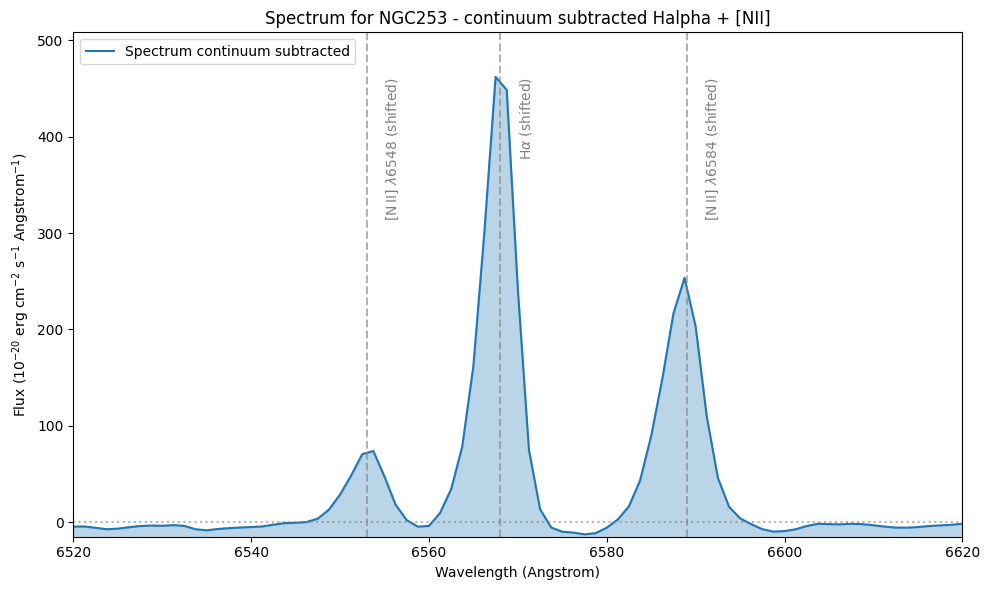

In [8]:
# Define key emission lines in Angstrom
lines = {
    r'[N II] $\lambda6548$': 6548,
    r'H$\alpha$': 6563,
    r'[N II] $\lambda6584$': 6584,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Spectrum continuum subtracted')
ax.fill_between(data_wave, -20, data_spec, where=(data_spec > -20), alpha=0.3, color='C0')
ax.hlines(0, data_wave[0], data_wave[-1], color='gray', linestyle=':', alpha=0.6)

# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave+5, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 7, np.nanmax(data_spec), 
                label+' (shifted)', 
                rotation=90, verticalalignment='top', fontsize=10, color='gray')
        # Note here we shift the lines to match the systemic velocity of the region

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target} - continuum subtracted Halpha + [NII]')

ax.set_ylim(-15, np.nanmax(data_spec) * 1.1)  # Set y-limits to avoid clipping
ax.set_xlim(6520, 6620)

ax.legend()
fig.tight_layout()
fig.savefig("./figures/muse_ngc253_spectrum_halpha.png", dpi=300, bbox_inches='tight')

#### **Plot downloaded data (map)** 

Plot the maps of the Halpha + [NII] emission and the continuum, which are the sum and median over the spectral dimension, respectively.

We also mark the position of interest on both maps (at pixel = `[145, 250]`) - for which we will extract the full spectrum in the next step (note, aperture not to scale).

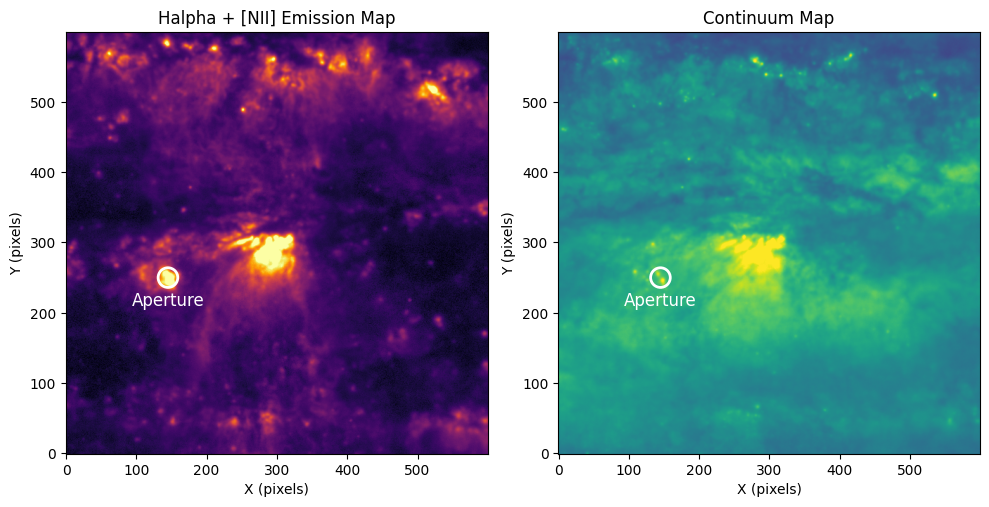

In [9]:
pos = [145, 250]

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

map1 = np.sqrt(np.abs(data_line)) # included abs here to avoid error on sqrt of negative values
map2 = np.sqrt(np.abs(data_cont))

cmap1 = plt.cm.inferno
cmap2 = plt.cm.viridis
cmap1.set_bad(color=cmap1(0))
cmap2.set_bad(color=cmap2(0))

ax1.imshow(map1, origin='lower', cmap=cmap1, vmin=np.nanpercentile(map1, 0), vmax=np.nanpercentile(map1, 99.5))
ax2.imshow(map2, origin='lower', cmap=cmap2, vmin=0, vmax=np.nanpercentile(map2, 99.5))

ax1.scatter(pos[0], pos[1], color='white', marker='o', s=200, lw=2, fc='none')
ax2.scatter(pos[0], pos[1], color='white', marker='o', s=200, lw=2, fc='none')

ax1.text(pos[0], pos[1] - 20, 'Aperture', color='white', fontsize=12, ha='center', va='top')
ax2.text(pos[0], pos[1] - 20, 'Aperture', color='white', fontsize=12, ha='center', va='top')

ax1.set_title('Halpha + [NII] Emission Map')
ax2.set_title('Continuum Map')
ax1.set_xlabel('X (pixels)')
ax2.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax2.set_ylabel('Y (pixels)')

fig.tight_layout()
fig.savefig("./figures/muse_ngc253_maps_halpha.png", dpi=300, bbox_inches='tight')

### **Get the full spectrum at the position of interest (e.g. HII region)**
Now we can extract the full spectrum at the position of interest, which is the position of the HII region in NGC 253. 

First need need to get the real world position of the aperture (see maps above), which is used to extract the spectrum.

In [10]:
wcs = WCS(hdul[1].header)
coords = wcs.pixel_to_world(pos[0], pos[1], 0)[0]
print(f"Position in sky coordinates: {coords.to_string('decimal')} degrees")
print(f"Position in sky coordinates: {coords.to_string('hmsdms')}")
print(f"Position in pixel coordinates: {pos[0]}, {pos[1]}")

ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
radius = (1*u.arcsec).to("deg").value # Radius in degrees

Position in sky coordinates: 11.8974 -25.2855 degrees
Position in sky coordinates: 00h47m35.37532805s -25d17m07.84008262s
Position in pixel coordinates: 145, 250


Then, as before, we use our `get_cutout` function to retrieve the full spectrum at that position (note the lack of constraints on `wave_min` and `wave_max`, which means we get the full spectral cutout), also note here we extract a small cutout of only 1 arcsec radius (approx a single psf for these data) that we will average over the spatial dimensions to get the full spectrum.

In [11]:
# Get the cutout from the ESO Data Portal
# Given no constraints on wavelength, we get the full cutout
outdir = "./data/"
outfile = "cutout2.fits"
outfile = get_cutout(dp_id, ra, dec, radius, 
                      outdir=outdir, outfile=outfile, 
                      verbose=True, overwrite=True)

# Open the cutout FITS file and return the HDU list
hdul = fits.open(outfile)

Requesting cutout from URL: https://dataportal.eso.org/dataPortal/soda/sync?ID=ADP.2025-07-06T07:52:11.871&CIRCLE=11.897397200217583+-25.2855111340605+0.000278
Estimated download size: 3.5 MB


Downloading: 100%|██████████| 3.53M/3.53M [00:00<00:00, 8.89MB/s]

Wrote: data/cutout2.fits


> **Note:** If you receive a timeout error when making the above call, this is normal for such a large dataset. Please try again — depending on server traffic, it can take several retries before succeeding.

As before, we extract the spectrum... 

In [12]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxis(hdul) # Get the wavelength axes from the FITS file
masked_data = np.ma.masked_invalid(data) # mask invalid values in the data (possible that some channels have all NaN values)
data_spec = masked_data.mean(axis=(1, 2)).filled(np.nan)

And finally plot the full spectrum, on which we label a number of important emission lines. 

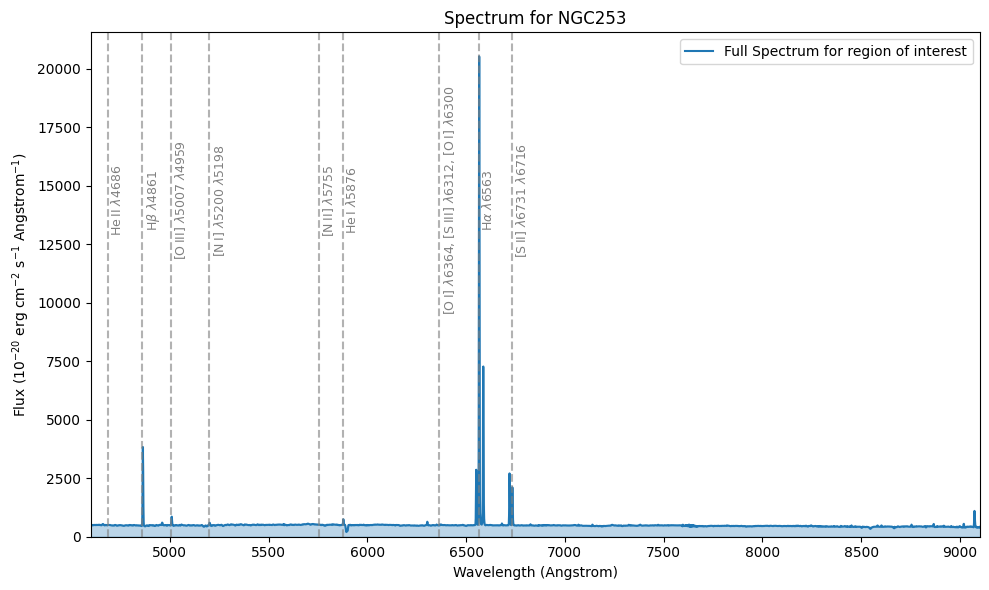

In [13]:
# Define some key emission lines in Angstrom
# Some are very close together and as such we group them... 
lines = {
    r'He II $\lambda$4686': 4686,
    r'H$\beta$ $\lambda$4861': 4861,
    # r'[O III] $\lambda$4959': 4959,
    r'[O III] $\lambda$5007 $\lambda$4959': 5007,
    # r'[N I] $\lambda$5198': 5198,
    r'[N I] $\lambda$5200 $\lambda$5198': 5200,
    r'[N II] $\lambda$5755': 5755,
    r'He I $\lambda$5876': 5876,
    # r'[O I] $\lambda$6300': 6300,
    # r'[S III] $\lambda$6312': 6312,
    r'[O I] $\lambda$6364, [S III] $\lambda$6312, [O I] $\lambda$6300': 6364,
    # r'[N II] $\lambda$6548': 6548,
    r'H$\alpha$ $\lambda$6563': 6563,
    # r'[N II] $\lambda$6584': 6584,
    # r'[S II] $\lambda$6716': 6716,
    r'[S II] $\lambda$6731 $\lambda$6716': 6731,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Full Spectrum for region of interest')
ax.fill_between(data_wave, 0, data_spec, where=(data_spec > 0), alpha=0.3, color='C0')

# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 12, np.nanmax(data_spec) * 0.7, label, rotation=90,
                verticalalignment='center', fontsize=9, color='gray')

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target}')

ax.set_ylim(0, np.nanmax(data_spec) * 1.05)  # Set y-limits to avoid clipping
ax.set_xlim(4600, 9100)

ax.legend()
fig.tight_layout()
fig.savefig("./figures/muse_ngc253_spectrum_full.png", dpi=300, bbox_inches='tight')

<hr style="border:2px solid #0281c9"> </hr>